# Perspective Shift Identification

### Goal: 
Use ML to identify perspective shift in movement of distribution centers

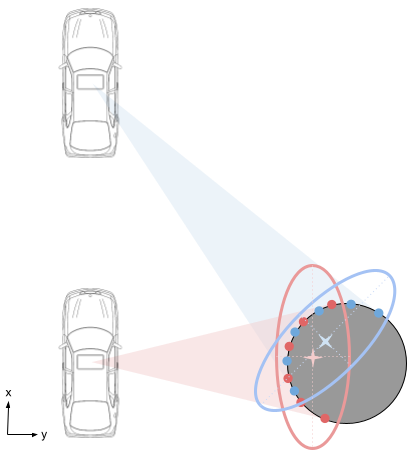

### Assumptions:
Gross rotation and translation have already been estimated by previous scan matching iterations

### Network structure:
Inputs: 
xyz of 50 points randomly sampled from each distribution

Output:
Per-voxel translation estimates that best register the cluster of points within each cell 


### Training data generation

(starting with toy example)

1- generate grid of simple shapes in Inventor

2- Rotate randomly, translate randomly and simulate lidar scan of shapes at 2 points in time using MatLab script

3- Sample N points from each object and save to file. Also store information on rotation and translation to seperate file

4- import data here and augment again by duplicating and scaling examples arbitrarily

## TODO

Design test network that can guess the direction of ambiguity

    Use LUT as y_train, Try ULUT

Scale allowable error threshold between DNN and D2D by radial disatance from origin


NOTE: py39 env needed with new GPU setup
https://www.tensorflow.org/install/source#gpu


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime
# import tensorflow_graphics as tfg
# import tensorflow_graphics.nn.layer.pointnet

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 20*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

print(tf.__version__) #requires tensorflow 2.3

# %matplotlib inline
# plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
%matplotlib notebook

%load_ext tensorboard

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

2022-10-07 00:04:41.547346: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-07 00:04:41.640416: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-07 00:04:41.963221: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-07 00:04:41.963257: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0


2022-10-07 00:04:42.749936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 00:04:42.768713: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 00:04:42.768834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Autosaving every 180 seconds


In [2]:
#test pointnet layer...
import tensorflow_graphics as tfg
# tfg.nn.layer.pointnet #works in TF2.9 (with CUDNN 8.x)

In [3]:
#define functions to convert between spherical and cartesian coordinate representations
def c2s(pts):
    """ converts points from cartesian coordinates to spherical coordinates """
    r = tf.sqrt(pts[:,0]**2 + pts[:,1]**2 + pts[:,2]**2)
    phi = tf.math.acos(pts[:,2]/r)
    theta = tf.math.atan2(pts[:,1], pts[:,0])

    out = tf.transpose(tf.Variable([r, theta, phi]))
    return(out)
def s2c(pts):
    """converts spherical -> cartesian"""

    x = pts[:,:,0]*tf.math.sin(pts[:,:,2])*tf.math.cos(pts[:,:,1])
    y = pts[:,:,0]*tf.math.sin(pts[:,:,2])*tf.math.sin(pts[:,:,1]) 
    z = pts[:,:,0]*tf.math.cos(pts[:,:,2])

    out = tf.transpose(tf.Variable([x, y, z]))
    # out = tf.Variable([x, y, z])
    return(out)

In [ ]:
# old way - non-reduced dimension solution, only feed DNN each point cloud
# # #_________________________________________________________________
# # #load individual data numpy files

# d1_1 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0091v2_scan1_50pts.npy")
# d2_1 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0091v2_scan2_50pts.npy")
# gt_1 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0091v2_ground_truth_50pts.npy")

# d1_2 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0005_scan1_50pts.npy")
# d2_2 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0005_scan2_50pts.npy")
# gt_2 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0005_ground_truth_50pts.npy")
# d1 = np.append(d1_1, d1_2, axis = 0)
# d2 = np.append(d2_1, d2_2, axis = 0)
# gt = np.append(gt_1, gt_2, axis = 0)

# d1_3 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0095_scan1_50pts.npy")
# d2_3 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0095_scan2_50pts.npy")
# gt_3 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0095_ground_truth_50pts.npy")
# d1 = np.append(d1, d1_3, axis = 0)
# d2 = np.append(d2, d2_3, axis = 0)
# gt = np.append(gt, gt_3, axis = 0)

# d1_4 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0117_scan1_50pts.npy")
# d2_4 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0117_scan2_50pts.npy")
# gt_4 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0117_ground_truth_50pts.npy")
# d1 = np.append(d1, d1_4, axis = 0)
# d2 = np.append(d2, d2_4, axis = 0)
# gt = np.append(gt, gt_4, axis = 0)

# # d1_5 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0071v2_scan1_50pts.npy")
# # d2_5 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0071v2_scan2_50pts.npy")
# # gt_5 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0071v2_ground_truth_50pts.npy")
# # d1 = np.append(d1, d1_5, axis = 0)
# # d2 = np.append(d2, d2_5, axis = 0)
# # gt = np.append(gt, gt_5, axis = 0)

# d1_6 = np.loadtxt("/media/derm/06EF-127D1/TrainingData/ModelNet40/50pts_scan1_320k.txt")
# d2_6 = np.loadtxt("/media/derm/06EF-127D1/TrainingData/ModelNet40/50pts_scan2_320k.txt")
# gt_6 = np.loadtxt("/media/derm/06EF-127D1/TrainingData/ModelNet40/50pts_ground_truth_320k.txt")*0.1
# d1 = np.append(d1, d1_6, axis = 0)
# d2 = np.append(d2, d2_6, axis = 0)
# gt = np.append(gt, gt_6, axis = 0)


# # d1_2 = np.load("/media/derm/06EF-127D1/TrainingData/CODD_big_scan1_50pts.npy")
# # d2_2 = np.load("/media/derm/06EF-127D1/TrainingData/CODD_big_scan2_50pts.npy")
# # gt_2 = np.load("/media/derm/06EF-127D1/TrainingData/CODD_big_ground_truth_50pts.npy")
# # #_________________________________________________________________

# small
# d1 = np.loadtxt("training_data/ICET_Ford_scan1.txt")
# d2 = np.loadtxt("training_data/ICET_Ford_scan2.txt")
# gt = np.loadtxt("training_data/ICET_Ford_ground_truth.txt")

# big
# d1 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0117_scan1_50pts.npy")
# d2 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0117_scan2_50pts.npy")
# gt = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0117_ground_truth_50pts.npy")
# d1 = np.load("/media/derm/06EF-127D1/TrainingData/CODD_big_scan1_50pts.npy")
# d2 = np.load("/media/derm/06EF-127D1/TrainingData/CODD_big_scan2_50pts.npy")
# gt = np.load("/media/derm/06EF-127D1/TrainingData/CODD_big_ground_truth_50pts.npy")

#shadowed ModelNet40 data
d1 = np.load("/media/derm/06EF-127D1/TrainingData/ModelNet40/100pts_scan1_320k.npy")
d2 = np.load("/media/derm/06EF-127D1/TrainingData/ModelNet40/100pts_scan2_320k.npy")
gt = np.load("/media/derm/06EF-127D1/TrainingData/ModelNet40/100pts_ground_truth_320k.npy")

#reshape but don't convert to tensor
points_per_sample = 100 #100 #50          #points sammpled from each voxel
tsplit = 0.95                   #this fraction goes into training

scan1 = np.reshape(d1, [-1, points_per_sample, 3])
scan2 = np.reshape(d2, [-1, points_per_sample, 3])
ntrain = int(tsplit*tf.shape(scan1)[0].numpy())

x_train = np.append(scan1[:ntrain], scan2[:ntrain], axis = 1)
x_test = np.append(scan1[ntrain:], scan2[ntrain:], axis = 1)
print(np.shape(x_train))
# print(np.shape(x_test))

y_train = gt[:ntrain] #for standard training/ test data
y_test = gt[ntrain:]

In [4]:
#uniformly sampled ModelNet40 data
points_per_sample = 100
# x_train = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/full_ModelNet40_x_train.npy')
# y_train = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/full_ModelNet40_y_train.npy')
# x_test = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/full_ModelNet40_x_test.npy')
# y_test = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/full_ModelNet40_y_test.npy')

x_train = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/full_simple_ModelNet40_x_train.npy')
y_train = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/full_simple_ModelNet40_y_train.npy')
x_test = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/full_simple_ModelNet40_x_test.npy')
y_test = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/full_simple_ModelNet40_y_test.npy')

# x_train = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/toilet_ModelNet40_x_train.npy')
# y_train = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/toilet_ModelNet40_y_train.npy')
# x_test = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/toilet_ModelNet40_x_test.npy')
# y_test = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/toilet_ModelNet40_y_test.npy')

print(np.shape(x_train))


(360000, 200, 3)


In [ ]:
# np.save("/media/derm/06EF-127D1/TrainingData/ModelNet40/100pts_scan1_320k.npy",d1)
# np.save("/media/derm/06EF-127D1/TrainingData/ModelNet40/100pts_scan2_320k.npy",d2)
# np.save("/media/derm/06EF-127D1/TrainingData/ModelNet40/100pts_ground_truth_320k.npy",gt)
print(np.shape(x_test))

In [ ]:
#Testing new network structure informed by voxel boundaries
#   input both point clouds AND VOXEL BOUNDS to DNN
#_________________________________________________________________
# big
#old
# d1 = np.load("C:/Users/Derm/Desktop/big/pshift/compact_scan1.npy")
# d2 = np.load("C:/Users/Derm/Desktop/big/pshift/compact_scan2.npy")
# gt = np.load("C:/Users/Derm/Desktop/big/pshift/compact_ground_truth.npy")
# LUT = np.load("C:/Users/Derm/Desktop/big/pshift/LUT.npy")
# L = np.load("C:/Users/Derm/Desktop/big/pshift/L.npy")
# U = np.load("C:/Users/Derm/Desktop/big/pshift/U.npy")
# corn = np.load("C:/Users/Derm/Desktop/big/pshift/corn.npy")
d1 = np.load("D:/TrainingData/compact/compact_scan1.npy")
d2 = np.load("D:/TrainingData/compact/compact_scan2.npy")
gt = np.load("D:/TrainingData/compact/compact_ground_truth.npy")
LUT = np.load("D:/TrainingData/compact/LUT.npy")
L = np.load("D:/TrainingData/compact/L.npy")
U = np.load("D:/TrainingData/compact/U.npy")
corn = np.load("D:/TrainingData/compact/corn.npy")

#small
# d1 = np.load('training_data/compact_scan1.npy')
# d2 = np.load('training_data/compact_scan2.npy')
# gt = np.load('training_data/compact_ground_truth.npy')
# LUT = np.load('training_data/LUT.npy') 
# L = np.load('training_data/L.npy')
# U = np.load('training_data/U.npy')
# corn = np.load('training_data/corn.npy')
#_________________________________________________________________

#loop through each element of corn and convert from spherical to cartesian
# print(np.shape(corn))
new_corn = np.transpose(s2c(corn), [1,0,2,])
# print(np.shape(new_corn))

#reshape but don't convert to tensor
points_per_sample = 50          #poitns sammpled from each voxel
tsplit = 0.9 #0.95                   #this fraction goes into training

scan1 = np.reshape(d1, [-1, points_per_sample, 3])
scan2 = np.reshape(d2, [-1, points_per_sample, 3])
ntrain = int(tsplit*tf.shape(scan1)[0].numpy())

x_train = np.append(scan1[:ntrain], scan2[:ntrain], axis = 1)
x_test = np.append(scan1[ntrain:], scan2[ntrain:], axis = 1)

#combine voxel bound to each training example
x_train = np.append(x_train, new_corn[:ntrain], axis = 1)
x_test = np.append(x_test, new_corn[ntrain:], axis = 1)

y_train = gt[:ntrain] #for standard training/ test data
y_test = gt[ntrain:]
# y_train = gt[:ntrain][:,:,0] #when using compact data
# y_test = gt[ntrain:][:,:,0]
LUT_test = tf.convert_to_tensor(LUT)[ntrain:]
LUT = tf.convert_to_tensor(LUT)[:ntrain] #using from file

U = tf.convert_to_tensor(U)[:ntrain]
L = tf.convert_to_tensor(L)[:ntrain]
corn_train = corn[:ntrain]
corn_test = corn[ntrain:]

print(np.shape(x_train))
# print(np.shape(x_test))

In [ ]:
compact = tf.matmul(U, tf.matmul(L, tf.transpose(U, [0,2,1])))#[:ntrain]
print(np.shape(U))
print(np.shape(compact))
print(np.shape(LUT))

In [ ]:
## Rescaling and zero-centing each point cloud
#100 pts per scan
# d1 = np.load("D:/TrainingData/Ford_scan1_100pts.npy")
# d2 = np.load("D:/TrainingData/Ford_scan2_100pts.npy")
# gt = np.load("D:/TrainingData/Ford_ground_truth_100pts.npy")
d1 = np.load("D:/TrainingData/Ford_scan1_100pts_large_displacement.npy")
d2 = np.load("D:/TrainingData/Ford_scan2_100pts_large_displacement.npy")
gt = np.load("D:/TrainingData/Ford_ground_truth_100pts_large_displacement.npy")

#reshape but don't convert to tensor
points_per_sample = 100 #50          #poitns sammpled from each voxel
tsplit = 0.95 #0.95                   #this fraction goes into training

scan1 = np.reshape(d1, [-1, points_per_sample, 3])
scan2 = np.reshape(d2, [-1, points_per_sample, 3])
ntrain = int(tsplit*tf.shape(scan1)[0].numpy())

#center about zero
mu1 = np.mean(scan1, axis = 1)[:, None, :]
scan1 = scan1 - mu1
scan2 = scan2 - mu1

#make unit scale
RMS = np.std(scan1, axis=(1,2))
scan1 = scan1/RMS[:,None,None]

mu2 = np.mean(scan2, axis = 1)[:, None, :]
scan2 = scan2/RMS[:,None,None]
gt = gt/RMS[:,None]

x_train = np.append(scan1[:ntrain], scan2[:ntrain], axis = 1)
x_test = np.append(scan1[ntrain:], scan2[ntrain:], axis = 1)

y_train = gt[:ntrain] #for standard training/ test data
y_test = gt[ntrain:]
# print(np.shape(x_train))

## Create TF dataset to augment data

In [5]:
def augment(points, gt):
    # jitter points
#     points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float32)
#     points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64) #try this if above doesn't work

    # shuffle points in first point cloud
#     points = tf.concat([tf.random.shuffle(points[:50]), tf.random.shuffle(points[50:100]), points[100:]], axis = 0)
#     points = tf.concat([tf.random.shuffle(points[:100]), tf.random.shuffle(points[100:200]), points[200:]], axis = 0)

    #TEST- shuffle and randomly translate cloud 2 and ground truth -- why is this not working???
    shift_scale = 1 #don't want to make this too large for PC to reach in 1 iter(?)
    shift = tf.cast(tf.concat([shift_scale*tf.random.normal([3])], axis=0) , tf.float64)
    points = tf.concat([tf.random.shuffle(points[:100]), tf.random.shuffle(points[100:]) + shift[:3]], axis = 0)
    gt += shift

    return points, gt

BATCH_SIZE = 1024

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(len(x_train)).map(augment).batch(BATCH_SIZE)
print(train_dataset)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.shuffle(len(x_test)).map(augment).batch(BATCH_SIZE)
print(val_dataset)

2022-10-07 00:04:51.676564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-07 00:04:51.677120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 00:04:51.677261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 00:04:51.677356: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

<BatchDataset element_spec=(TensorSpec(shape=(None, 200, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 200, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>



| Error      | Batch Size     |    Epochs | Train Dataset | Notes | Filename|
| ----------- | ----------- | --------- | --------   | | |
| 0.0407 MAE  | 256   | 32    | KITTI(5,91,95)x50pts| Extended PCR-NET|  |
| 0.0399 MAE  | 1024   | 32    | KITTI(5,91,95)x50pts| Extended PCR-NET|  |
| 0.0429 MAE  | 128   | 100    | KITTI(5,91,95)x50pts| Extended PCR-NET|  |
| 0.0411 MAE  | 1024   | 8    | KITTI(117)x50pts| Extended PCR-NET|  |
| 0.0311 MAE  | 1024   | 100    | KITTI(5,91,95,117)x50pts| Extended PCR-NET| KITTInet |
| 0.0478 MAE  | 1024   | 64    | KITTI(5,91,95,117, 71)x50pts| Extended PCR-NET|  |

# Train Network

In [6]:
# from network import Net #for shadowed 
# from network import smallNet as Net #for basic uniformly sampled surfaces
from network import TestNet as Net
# from network import LUT_test as Net
# from network import FFNet as Net
# from network import PointNet as Net
# from network import Attention as Net

runLen = 64

def scheduler(epoch, learning_rate):
    part1 = runLen//4
    part2 = 2*runLen//4
    part3 = 3*runLen//4
    
    if epoch < part1:
        learning_rate = 0.0005
        return learning_rate
    if epoch >= part1 and epoch < part2:
        learning_rate = 0.0001       
        return learning_rate
    if epoch >= part2 and epoch < part3:
        learning_rate = 0.00005     
        return learning_rate
    if epoch >= part3:
        learning_rate = 0.00001
        return learning_rate

model = Net() #comment out to re-train existing network
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = tf.keras.losses.MeanAbsoluteError()) #was MeanSquaredError()

summary = model.summary()
print(summary)
scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
cp = tf.keras.callbacks.ModelCheckpoint("CP.kmod", monitor = 'val_loss', save_best_only = True) 

log_dir = "runs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# trace = model.fit(x = x_train, y = y_train, batch_size = 128, epochs=runLen, verbose=1, 
#                   validation_split = 0.2, shuffle=True, callbacks = [cp, scheduler])

#using tf.data() pipeline instead of simply feeding in np arrays
trace = model.fit(train_dataset, epochs=runLen, validation_data = val_dataset, 
                  verbose=1, callbacks = [cp,scheduler])

#test- see if network can learn LUT
# trace = model.fit(x = x_train, y = compact, batch_size = 2048, epochs=runLen, verbose=1, 
#                   validation_split = 0.2, shuffle=True, callbacks = [cp, scheduler])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 3)]          0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 200, 3, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 200, 1, 256)       1024      
                                                                 
 batch_normalization (BatchN  (None, 200, 1, 256)      1024      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 1, 256)       65792     
                                                                 
 batch_normalization_1 (Batc  (None, 200, 1, 256)      1024      
 hNormalization)                                             

2022-10-07 00:04:57.772728: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-10-07 00:04:58.044249: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-10-07 00:04:58.045596: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-10-07 00:04:58.045603: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-10-07 00:04:58.045630: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

352/352 [==============================] - ETA: 0s - loss: 0.3642

INFO:tensorflow:Assets written to: CP.kmod/assets


INFO:tensorflow:Assets written to: CP.kmod/assets


352/352 [==============================] - 45s 121ms/step - loss: 0.3642 - val_loss: 0.8962 - lr: 5.0000e-04
Epoch 2/64
352/352 [==============================] - ETA: 0s - loss: 0.1381

INFO:tensorflow:Assets written to: CP.kmod/assets


INFO:tensorflow:Assets written to: CP.kmod/assets


352/352 [==============================] - 43s 122ms/step - loss: 0.1381 - val_loss: 0.1157 - lr: 5.0000e-04
Epoch 3/64
352/352 [==============================] - 40s 113ms/step - loss: 0.1229 - val_loss: 0.1408 - lr: 5.0000e-04
Epoch 4/64
352/352 [==============================] - 40s 113ms/step - loss: 0.1120 - val_loss: 0.1291 - lr: 5.0000e-04
Epoch 5/64
352/352 [==============================] - ETA: 0s - loss: 0.1048

INFO:tensorflow:Assets written to: CP.kmod/assets


INFO:tensorflow:Assets written to: CP.kmod/assets


352/352 [==============================] - 42s 119ms/step - loss: 0.1048 - val_loss: 0.1108 - lr: 5.0000e-04
Epoch 6/64
352/352 [==============================] - ETA: 0s - loss: 0.1018

INFO:tensorflow:Assets written to: CP.kmod/assets


INFO:tensorflow:Assets written to: CP.kmod/assets


352/352 [==============================] - 42s 120ms/step - loss: 0.1018 - val_loss: 0.1057 - lr: 5.0000e-04
Epoch 7/64
352/352 [==============================] - 40s 113ms/step - loss: 0.0984 - val_loss: 0.1106 - lr: 5.0000e-04
Epoch 8/64
352/352 [==============================] - ETA: 0s - loss: 0.0960

INFO:tensorflow:Assets written to: CP.kmod/assets


INFO:tensorflow:Assets written to: CP.kmod/assets


352/352 [==============================] - 42s 120ms/step - loss: 0.0960 - val_loss: 0.0873 - lr: 5.0000e-04
Epoch 9/64
352/352 [==============================] - 40s 114ms/step - loss: 0.0946 - val_loss: 0.1129 - lr: 5.0000e-04
Epoch 10/64
352/352 [==============================] - ETA: 0s - loss: 0.0939

INFO:tensorflow:Assets written to: CP.kmod/assets


INFO:tensorflow:Assets written to: CP.kmod/assets


352/352 [==============================] - 41s 115ms/step - loss: 0.0939 - val_loss: 0.0870 - lr: 5.0000e-04
Epoch 11/64
352/352 [==============================] - 39s 109ms/step - loss: 0.0898 - val_loss: 0.1034 - lr: 5.0000e-04
Epoch 12/64
352/352 [==============================] - 39s 109ms/step - loss: 0.0915 - val_loss: 0.1074 - lr: 5.0000e-04
Epoch 13/64
352/352 [==============================] - 39s 109ms/step - loss: 0.0898 - val_loss: 0.1052 - lr: 5.0000e-04
Epoch 14/64
352/352 [==============================] - 39s 109ms/step - loss: 0.0879 - val_loss: 0.0951 - lr: 5.0000e-04
Epoch 15/64
352/352 [==============================] - 41s 114ms/step - loss: 0.0881 - val_loss: 0.0925 - lr: 5.0000e-04
Epoch 16/64
352/352 [==============================] - 40s 113ms/step - loss: 0.0884 - val_loss: 0.1071 - lr: 5.0000e-04
Epoch 17/64
352/352 [==============================] - ETA: 0s - loss: 0.0666

INFO:tensorflow:Assets written to: CP.kmod/assets


INFO:tensorflow:Assets written to: CP.kmod/assets


352/352 [==============================] - 43s 120ms/step - loss: 0.0666 - val_loss: 0.0528 - lr: 1.0000e-04
Epoch 18/64
352/352 [==============================] - 40s 113ms/step - loss: 0.0650 - val_loss: 0.0563 - lr: 1.0000e-04
Epoch 19/64
352/352 [==============================] - 40s 113ms/step - loss: 0.0651 - val_loss: 0.0622 - lr: 1.0000e-04
Epoch 20/64
352/352 [==============================] - ETA: 0s - loss: 0.0647

INFO:tensorflow:Assets written to: CP.kmod/assets


INFO:tensorflow:Assets written to: CP.kmod/assets


352/352 [==============================] - 42s 120ms/step - loss: 0.0647 - val_loss: 0.0464 - lr: 1.0000e-04
Epoch 21/64
352/352 [==============================] - 40s 113ms/step - loss: 0.0641 - val_loss: 0.0620 - lr: 1.0000e-04
Epoch 22/64
352/352 [==============================] - 40s 113ms/step - loss: 0.0633 - val_loss: 0.0522 - lr: 1.0000e-04
Epoch 23/64
352/352 [==============================] - 40s 113ms/step - loss: 0.0653 - val_loss: 0.0647 - lr: 1.0000e-04
Epoch 24/64
352/352 [==============================] - 40s 114ms/step - loss: 0.0640 - val_loss: 0.0551 - lr: 1.0000e-04
Epoch 25/64
352/352 [==============================] - 40s 113ms/step - loss: 0.0627 - val_loss: 0.0556 - lr: 1.0000e-04
Epoch 26/64
352/352 [==============================] - 40s 114ms/step - loss: 0.0632 - val_loss: 0.0470 - lr: 1.0000e-04
Epoch 27/64
352/352 [==============================] - 40s 114ms/step - loss: 0.0630 - val_loss: 0.0491 - lr: 1.0000e-04
Epoch 28/64
352/352 [=======================

INFO:tensorflow:Assets written to: CP.kmod/assets


INFO:tensorflow:Assets written to: CP.kmod/assets


352/352 [==============================] - 43s 122ms/step - loss: 0.0579 - val_loss: 0.0458 - lr: 5.0000e-05
Epoch 35/64
352/352 [==============================] - 42s 118ms/step - loss: 0.0580 - val_loss: 0.0476 - lr: 5.0000e-05
Epoch 36/64
352/352 [==============================] - 42s 118ms/step - loss: 0.0575 - val_loss: 0.0558 - lr: 5.0000e-05
Epoch 37/64
352/352 [==============================] - 42s 118ms/step - loss: 0.0577 - val_loss: 0.0579 - lr: 5.0000e-05
Epoch 38/64
352/352 [==============================] - ETA: 0s - loss: 0.0573

INFO:tensorflow:Assets written to: CP.kmod/assets


INFO:tensorflow:Assets written to: CP.kmod/assets


352/352 [==============================] - 42s 120ms/step - loss: 0.0573 - val_loss: 0.0396 - lr: 5.0000e-05
Epoch 39/64
352/352 [==============================] - 41s 115ms/step - loss: 0.0566 - val_loss: 0.0445 - lr: 5.0000e-05
Epoch 40/64
352/352 [==============================] - 41s 116ms/step - loss: 0.0573 - val_loss: 0.0492 - lr: 5.0000e-05
Epoch 41/64
352/352 [==============================] - 41s 116ms/step - loss: 0.0574 - val_loss: 0.0473 - lr: 5.0000e-05
Epoch 42/64
352/352 [==============================] - 41s 116ms/step - loss: 0.0567 - val_loss: 0.0547 - lr: 5.0000e-05
Epoch 43/64
352/352 [==============================] - 41s 116ms/step - loss: 0.0549 - val_loss: 0.0452 - lr: 5.0000e-05
Epoch 44/64
352/352 [==============================] - 41s 117ms/step - loss: 0.0563 - val_loss: 0.0423 - lr: 5.0000e-05
Epoch 45/64
352/352 [==============================] - 41s 115ms/step - loss: 0.0563 - val_loss: 0.0406 - lr: 5.0000e-05
Epoch 46/64
352/352 [=======================

INFO:tensorflow:Assets written to: CP.kmod/assets


INFO:tensorflow:Assets written to: CP.kmod/assets


352/352 [==============================] - 41s 115ms/step - loss: 0.0526 - val_loss: 0.0375 - lr: 1.0000e-05
Epoch 54/64
352/352 [==============================] - 39s 109ms/step - loss: 0.0515 - val_loss: 0.0415 - lr: 1.0000e-05
Epoch 55/64
352/352 [==============================] - 39s 109ms/step - loss: 0.0510 - val_loss: 0.0409 - lr: 1.0000e-05
Epoch 56/64
352/352 [==============================] - 39s 109ms/step - loss: 0.0515 - val_loss: 0.0412 - lr: 1.0000e-05
Epoch 57/64
352/352 [==============================] - 39s 109ms/step - loss: 0.0519 - val_loss: 0.0397 - lr: 1.0000e-05
Epoch 58/64
352/352 [==============================] - 39s 109ms/step - loss: 0.0516 - val_loss: 0.0404 - lr: 1.0000e-05
Epoch 59/64
352/352 [==============================] - ETA: 0s - loss: 0.0512

INFO:tensorflow:Assets written to: CP.kmod/assets


INFO:tensorflow:Assets written to: CP.kmod/assets


352/352 [==============================] - 41s 116ms/step - loss: 0.0512 - val_loss: 0.0353 - lr: 1.0000e-05
Epoch 60/64
352/352 [==============================] - 39s 109ms/step - loss: 0.0523 - val_loss: 0.0448 - lr: 1.0000e-05
Epoch 61/64
352/352 [==============================] - 39s 109ms/step - loss: 0.0514 - val_loss: 0.0426 - lr: 1.0000e-05
Epoch 62/64
352/352 [==============================] - 39s 109ms/step - loss: 0.0513 - val_loss: 0.0413 - lr: 1.0000e-05
Epoch 63/64
352/352 [==============================] - 39s 109ms/step - loss: 0.0517 - val_loss: 0.0412 - lr: 1.0000e-05
Epoch 64/64
352/352 [==============================] - 39s 109ms/step - loss: 0.0509 - val_loss: 0.0416 - lr: 1.0000e-05


<IPython.core.display.Javascript object>


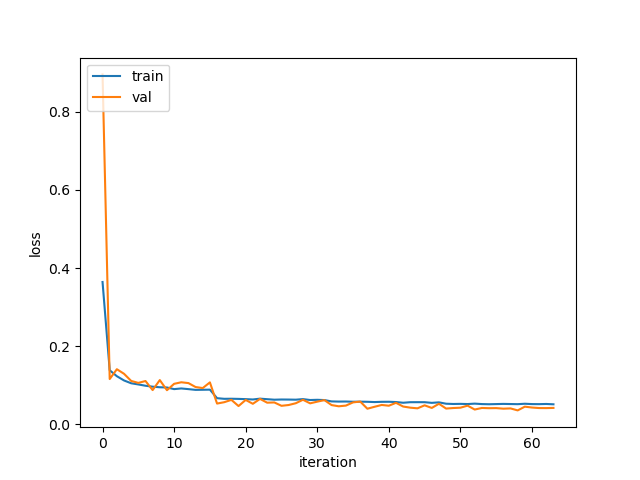

Text(0, 0.5, 'loss')

In [7]:
fig0, ax0 = plt.subplots()
ax0.plot(trace.history['loss'], '-')
ax0.plot(trace.history['val_loss'], '-')
ax0.legend(['train', 'val'], loc='upper left')
ax0.set_xlabel('iteration')
ax0.set_ylabel('loss')

In [8]:
# estimates = model.predict(x_train[0:100:16])
# print(estimates)
# print(y_train[0:100:16])
numtest = 1000 #100000
estimates = model.predict(x_test[:numtest]) #* 10
print("estimated translation x y z")
print(estimates)
print("actual translation x y z")
print(y_test[:numtest])

err = y_test[:numtest] - estimates
# err = y_train[0:100:16] - estimates

print("\n Error \n",err)

# print(tf.math.reduce_mean(tf.math.reduce_sum(err, axis = 1)))
print(np.sqrt(np.mean(err**2, axis = 0)))



32/32 [==============================] - 0s 2ms/step
estimated translation x y z
[[ 1.6112218  -1.4515847  -0.42104867]
 [-0.97737014  0.21487014  0.13582969]
 [-0.68996656 -0.67137694 -0.3481809 ]
 ...
 [ 0.0320504  -0.34552458  0.7759603 ]
 [ 0.24656242 -0.5017162  -1.8177595 ]
 [ 1.0385462  -1.2843544  -0.72052264]]
actual translation x y z
[[ 1.67521715 -1.50009978 -0.38376477]
 [-0.98145336  0.21474794  0.13488542]
 [-0.65817022 -0.70331347 -0.30273595]
 ...
 [ 0.08206315 -0.30390823  0.82169318]
 [ 0.25726032 -0.4888764  -1.82990324]
 [ 1.0943228  -1.32352328 -0.74440467]]

 Error 
 [[ 0.06399536 -0.04851508  0.0372839 ]
 [-0.00408322 -0.0001222  -0.00094427]
 [ 0.03179634 -0.03193653  0.04544494]
 ...
 [ 0.05001275  0.04161635  0.04573286]
 [ 0.0106979   0.01283979 -0.01214373]
 [ 0.0557766  -0.03916883 -0.02388203]]
[0.050426   0.02839236 0.03497616]


In [9]:
%%latex
$$
\begin{aligned}
& \text {Table 1.1. Performance on Normalized Training Data }\\
&\begin{array}{cccc}
\hline \hline \text { } & \text { Mean Absolute Error } & \text { Batch Size } & \text { Epochs } & \text {Notes} \\
\hline 
\text{Scaled and Zeroed} & 0.6297 & 4096 & 10 & \text {asdf } \\

\text{ModelNet40 (320k LIDAR)} & 0.0413 & 1024 & 32 & \text { -- } \\

\text{ModelNet40 320k LIDAR (100pts)} & 0.0322 & 1024 & 100 & \text {ModelNet100.kmod } \\

\text{ModelNet40 320k LIDAR (100pts)} & 0.0017 \text { MSE} & 1024 & 100 & \text {Net.kmod } \\

\text{ModelNet40 320k LIDAR (50pts)} & 0.0410 & 1024 & 100 & \text {ModelNet50.kmod } \\

\text{ModelNet40 LIDAR MAIN (100pts)} & 0.0321 & 1024 & 64 & \text {SmallNet.kmod } \\

- & - & - & - \\
- & - & - & - \\
\hline
\end{array}
\end{aligned}
$$

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


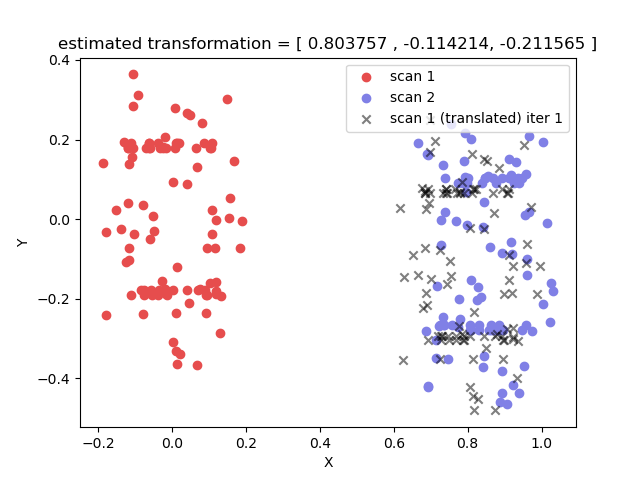

n =  1915
1/1 [==============================] - 0s 11ms/step

 correct soln [ 0.84137762 -0.08819967 -0.21247989]

 estiamted soln: [[ 0.80375719 -0.11421416 -0.21156506]]

 error from DNN: [[ 0.03762043  0.02601449 -0.00091483]]

 error in means [-0.00803942  0.01055987 -0.00251232]


In [16]:
#visualize results of network on test data
#2d plots (x and y only)
fig1, ax1 = plt.subplots()
n = int(np.floor(5000*np.random.rand()))
# n = 8 #sample number (from x_test)

print("n = ", n)

# print(tf.shape(x_test))
# c1 = np.array([x_test[n,:points_per_sample,0].numpy(), x_test[n,:points_per_sample,1].numpy(), x_test[n,:points_per_sample,2].numpy()])
# c2 = np.array([x_test[n,points_per_sample:,0].numpy(), x_test[n,points_per_sample:,1].numpy(), x_test[n,points_per_sample:,2].numpy()])
c1 = np.array([x_test[n,:points_per_sample,0], x_test[n,:points_per_sample,1], x_test[n,:points_per_sample,2]])
c2 = np.array([x_test[n,points_per_sample:(points_per_sample*2),0], x_test[n,points_per_sample:(points_per_sample*2),1], x_test[n,points_per_sample:(points_per_sample*2),2]])
ax1.scatter(c1[0,:], c1[1,:], color = [0.9, 0.3, 0.3], label = 'scan 1')
ax1.scatter(c2[0,:], c2[1,:], color = [0.5, 0.5, 0.9], label = 'scan 2')


inputs = x_test[n][None,:]
# print(x_test[n, 100:])
runlen = 1
corr_sum = np.zeros([1,3]) #init var to store correction contributions
for i in range(runlen):
    correction = model.predict(inputs)[0] #show what the network thinks
#     correction = correction*0.1
#     correction = y_test[n] #show actual solution
    corr_sum += correction
#     print(correction)
    c1 = np.array([c1[0,:] + correction[0], c1[1,:] + correction[1], c1[2,:] + correction[2]])
    inputs = np.append(c1, c2, axis = 1).T[None,:,:]
#     print(tf.shape(inputs))
#     print(tf.shape(x_test[n,None,100:]))
    inputs = np.append(inputs, x_test[n,None,2*points_per_sample:], axis = 1)
    moved = ax1.scatter(c1[0,:], c1[1,:], marker = 'x', color = [0., 0., 0., (i+1)/(runlen+1)],
                        label = 'scan 1 (translated) iter %i' %(i+1))

# moved = ax1.scatter(c1[0,:], c1[1,:], mar0ker = 'x', color = [0.9, 0.3, 0.3, (i+2)/(runlen+2)],
#                         label = 'scan 1 (translated)')

ax1.set_title("estimated transformation = [ %f , %f, %f ]" %(correction[0], correction[1], correction[2]))
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.legend(loc = 'best')

print("\n correct soln", y_test[n])
# print("\n y_test", y_test[n]*0.1)
print("\n estiamted soln:", corr_sum)
print("\n error from DNN:", y_test[n] - corr_sum)
print("\n error in means",  y_test[n] + (np.mean(x_test[n,:points_per_sample], axis = 0) - 
      np.mean(x_test[n,points_per_sample:], axis = 0)))

In [13]:
#use Vedo to plot inital and transformed point clouds in 3D 
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget

plt1 = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True)
disp = []

#draw scan1 
# disp.append(Points(x_test[n,:points_per_sample].numpy(), c = 'green', r = 5))
disp.append(Points(x_test[n,:points_per_sample], c = 'green', r = 5))

#draw initial scan2
# disp.append(Points(x_test[n,points_per_sample:].numpy(), c = 'red', r = 5))
disp.append(Points(x_test[n,points_per_sample:points_per_sample*2], c = 'red', r = 5))

#draw transformed scan2
disp.append(Points(c1, c = 'blue', r = 5))

plt1.show(disp, "Network Performance Test")
ViewInteractiveWidget(plt1.window)



ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1397)

In [ ]:
#save network
# model.save("ffnet10k25.kmod")
# model.save("Net.kmod")
# model.save("SmallNet.kmod")
# model.save("PIPEnet10.kmod")
# model.save("KITTInet.kmod")
# model.save("FordNet.kmod")
# model.save("FordNetV3.kmod")
# model.save("FordNetCP.kmod")
# model.save("ModelNet100pts.kmod")

#load network
# model = tf.keras.models.load_model("Net.kmod")
# model = tf.keras.models.load_model("SmallNet.kmod")
# model = tf.keras.models.load_model("FordNet.kmod")
# model = tf.keras.models.load_model("PIPEnet10.kmod")
# model = tf.keras.models.load_model("KITTInet.kmod")
# model = tf.keras.models.load_model("FORDNetV3.kmod")

# DNN Filter Paper Experiment #1 part b:
### PointNet vs D2D registration accuracy on individual objects __sampled with simulated LIDAR__

In [ ]:
out = model.predict(x_test)
print(np.shape(out))
print(out)
print(y_test)

In [ ]:
#load test data
d1 = np.load("training_data/compact_scan1.npy")
d2 = np.load("training_data/compact_scan2.npy")
gt = np.load("training_data/ground_truth.npy")
cgt = np.load("training_data/compact_ground_truth.npy")
LUT = np.load("training_data/LUT.npy")
L = np.load("training_data/L.npy")
U = np.load("training_data/U.npy")
corn = np.load("training_data/corn.npy")

#reshape but don't convert to tensor
points_per_sample = 50          #poitns sammpled from each voxel
tsplit = 0.5 #0.95                   #this fraction goes into training

scan1 = np.reshape(d1, [-1, points_per_sample, 3])
scan2 = np.reshape(d2, [-1, points_per_sample, 3])
ntrain = int(tsplit*tf.shape(scan1)[0].numpy())

x_train = np.append(scan1[:ntrain], scan2[:ntrain], axis = 1)
x_test = np.append(scan1[ntrain:], scan2[ntrain:], axis = 1)
print(np.shape(x_train))
print(np.shape(x_test))

y_train = gt[:ntrain] #for standard training/ test data
y_test = gt[ntrain:]

# y_train = gt[:ntrain][:,:,0] #when using compact data
# y_test = gt[ntrain:][:,:,0]
LUT = tf.convert_to_tensor(LUT)[ntrain:]
U = tf.convert_to_tensor(U)[ntrain:]
L = tf.convert_to_tensor(L)[ntrain:]
corn_train = corn[:ntrain]
corn_test = corn[ntrain:]

### Find average error in mean point locations when ground truth solution is applied
Test for indexing when geterating training data using Ford dataset - this error should be minimal when we are correctly indexing gt

In [ ]:
# d1 = np.loadtxt('training_data/ICET_Ford_scan1.txt') #available in repo
# d2 = np.loadtxt('training_data/ICET_Ford_scan2.txt')
# truth = np.loadtxt('training_data/ICET_Ford_ground_truth.txt')

points_per_sample = 100 #25 #50  #num pts per scan - defined in MatLab script
s1 = tf.reshape(tf.convert_to_tensor(d1), [-1, points_per_sample, 3])
s2 = tf.reshape(tf.convert_to_tensor(d2), [-1, points_per_sample, 3])
truth = tf.convert_to_tensor(gt)

In [ ]:
print(tf.shape(s1))
mu1 = tf.math.reduce_mean(s1, axis = 1)
mu2 = tf.math.reduce_mean(s2, axis = 1)
# print("\n mu1", mu1)
# print("\n mu2", mu2)
centers_error = mu1 - mu2 + truth 
# print("\n centers_error", centers_error)

#get mean absolute centers error across all voxels
# mace = tf.math.reduce_mean(abs(centers_error), axis = 0) #absolute error
mace = tf.math.reduce_mean(centers_error, axis = 0)
print("\n mace", mace)